# 1-Setup and preprocessing
    
    -Reshaping from 1D to 2D and normalize the training data
    
    -Binarizer encoding the training data
    
    -Splitting data into training and valdiation set
    
    
# 2-Building a CNN model


# 3-Training the CNN model
    
    -Selecting optimizer and setting initial learning rate
    
    -Specifying  learning rate reduction and setting checkpoints
    
    -Data augmentation
    
    -Setting number of epochs and training/validation batch sizes
    
    -Fitting the model
    
    -Displaying learning curves
    
    
# 4-Making predictions on the test data
    
    -Importing and Reshaping the test data from 1D to 2D
    
    -Predicting and saving the results

In [1]:
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dropout
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import *
from keras.layers.convolutional import MaxPooling2D
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline  

# 1-Set up and preprocessing

In [2]:
train=pd.read_csv('train.csv').values

In [3]:
train.shape

(42000, 785)

In [4]:
np.amax(train)

255

#### Reshape from 1D to 2D and normalize the training data

In [5]:
trainX = train[:, 1:].reshape(train.shape[0],28,28, 1).astype( 'float32' )
X_train = trainX/(np.amax(train)-np.amin(train))
X_train=np.array(X_train)

y_train = train[:,0]

In [6]:
X_train.shape

(42000, 28, 28, 1)

#### Binarizer encoding

In [7]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)


In [8]:
y_train=np.array(y_train)

In [9]:
X_train.shape

(42000, 28, 28, 1)

In [10]:
y_train.shape

(42000, 10)

#### Splitting data into training and valdiation set

In [11]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
trainX, validX, trainY, validY = train_test_split(X_train, y_train, test_size = 0.1, random_state=random_seed)

In [12]:
trainX.shape

(37800, 28, 28, 1)

In [13]:
validX.shape

(4200, 28, 28, 1)

[0 0 0 0 0 0 0 1 0 0]


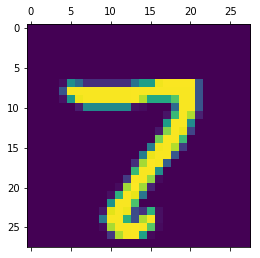

In [14]:
num= random.randint(1,trainX.shape[0])
print(trainY[num-1])
plt.matshow(trainX[num-1,:,:,0])

# 2-Building a CNN model

In [15]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(5,5), activation='relu',padding='same', input_shape=(28,28,1)))
model.add(Conv2D(32,kernel_size=(5,5), activation='relu',padding='same'))
model.add(Conv2D(32,kernel_size=(5,5), activation='relu',padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', data_format=None))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3), activation='relu',padding='same'))
model.add(Conv2D(64,kernel_size=(3,3), activation='relu',padding='same'))
model.add(Conv2D(64,kernel_size=(3,3), activation='relu',padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', data_format=None))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
__________

# 3-Training the CNN model

#### Selecting optimizer and setting initial learning rate

In [16]:
from keras.optimizers import Adam, RMSprop
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-8, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#### Specifying  learning rate reduction and setting checkpoints

In [17]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, min_lr=0.00001,  verbose=1)

In [19]:
checkpoint1 =keras.callbacks.ModelCheckpoint( 'nextLoss.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

checkpoint2 =keras.callbacks.ModelCheckpoint( 'nextValid_acc.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)


### Data augmentation

In [20]:
aug = ImageDataGenerator(rotation_range=10, zoom_range=0.1,width_shift_range=0.1,  height_shift_range=0.1)

### Setting number of epochs and training/validation batch sizes 

In [21]:
EPOCHS=100
TBS=200
VBS=200

### Fitting the model

In [22]:
history=model.fit_generator(
                aug.flow(trainX, trainY, batch_size=TBS),
                validation_data=(validX, validY), 
                callbacks=[reduce_lr,checkpoint1,checkpoint2], 
                validation_steps=validX.shape[0]/VBS, 
                steps_per_epoch=trainX.shape[0]/TBS, 
                epochs=EPOCHS, 
                verbose=2)


Epoch 1/100
 - 811s - loss: 0.7410 - acc: 0.7550 - val_loss: 0.0866 - val_acc: 0.9724

Epoch 00001: loss improved from inf to 0.74096, saving model to nextLoss.h5

Epoch 00001: val_acc improved from -inf to 0.97238, saving model to nextValid_acc.h5
Epoch 2/100
 - 808s - loss: 0.1849 - acc: 0.9457 - val_loss: 0.0531 - val_acc: 0.9850

Epoch 00002: loss improved from 0.74096 to 0.18488, saving model to nextLoss.h5

Epoch 00002: val_acc improved from 0.97238 to 0.98500, saving model to nextValid_acc.h5
Epoch 3/100
 - 840s - loss: 0.1220 - acc: 0.9654 - val_loss: 0.0810 - val_acc: 0.9755

Epoch 00003: loss improved from 0.18488 to 0.12200, saving model to nextLoss.h5

Epoch 00003: val_acc did not improve from 0.98500
Epoch 4/100
 - 837s - loss: 0.0947 - acc: 0.9723 - val_loss: 0.0392 - val_acc: 0.9876

Epoch 00004: loss improved from 0.12200 to 0.09469, saving model to nextLoss.h5

Epoch 00004: val_acc improved from 0.98500 to 0.98762, saving model to nextValid_acc.h5
 ...
 -------NOT DISP

### Displaying learning curves

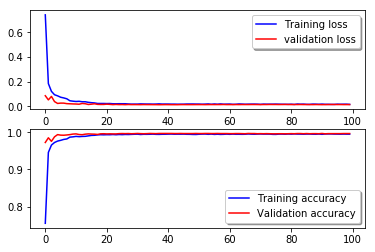

In [23]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# 4-Making predictions on the test data

### Importing and reshaping the test data from 1D to 2D 

In [24]:
test=pd.read_csv('test.csv').values
test.shape
testX = test.reshape(test.shape[0],1,28, 28).astype( 'float32' )
X_test = testX/255


In [25]:
X_test.shape

(28000, 1, 28, 28)

In [26]:
X_test=np.array(X_test)
X_test=np.transpose(X_test, (0,2, 3, 1))

In [27]:
X_test.shape

(28000, 28, 28, 1)

### Predicting and saving the results

In [28]:
results = model.predict(X_test)

In [29]:
# predict results
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [30]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("CNN-DigitRec.csv",index=False)